# **Sebastián Sanhueza O.**

# Transfer Learning

En este notebook resolveremos un problema real usando redes pre-entrenadas y transfer learning.

## Patrones geométricos de Kunisch
En el año 1998, Norbert Kunisch (un reconocido arqueólogo clásico alemán) publicó su libro "Ornamente Geometrischer Vasen", en donde clasificó diferentes patrones geométricos de vasijas griegas que se encuentran en diferentes museos de Europa. Su trabajo fue muy importante para determinar tiempos y ubicaciones de muchos objetos esparcidos por todo el continente.

Su libro es un compendio de los diferentes patrones geométricos presentes en vasijas y las anotaciones textuales de los patrones en diferentes idiomas.

<img src="http://www.ivan-sipiran.com/downloads/0.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/6.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/36.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/92.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/210.jpg" alt="Test" height="200" />








# El problema

En el museo de arqueología Schloss Eggenberg quieren realizar un análisis automático de patrones en vasijas usando el compendio de Kunisch. Para esto nosotros realizamos primero un trabajo de escaneo del libro entero y de OCR para extraer tanto los patrones como las anotaciones textuales.

Como resultado tenemos 348 patrones, clasificados en seis clases:

*   Ornamentos circulares
*   Ornamentos triangulares
*   Ornamenros rectangulares
*   Pictografías
*   Trazos y líneas
*   Romboidales

Nuestro primer objetivo es encontrar una forma de lograr una alta eficacia de clasificación de estos patrones. Sin embargo, al tener muy poca data, trataremos de resolverlo con la técnica dle transfer learning.



In [1]:
#Descargamos la data
!wget http://www.ivan-sipiran.com/downloads/data_patterns2.zip
!unzip data_patterns2.zip

--2023-10-27 22:19:26--  http://www.ivan-sipiran.com/downloads/data_patterns2.zip
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28575047 (27M) [application/zip]
Saving to: ‘data_patterns2.zip’

data_patterns2.zip  100%[===================>]  27.25M  14.0MB/s    in 1.9s    

2023-10-27 22:19:28 (14.0 MB/s) - ‘data_patterns2.zip’ saved [28575047/28575047]

Archive:  data_patterns2.zip
   creating: data/
  inflating: data/class_labels.csv   
  inflating: data/0.jpg              
  inflating: data/6.jpg              
  inflating: data/36.jpg             
  inflating: data/92.jpg             
  inflating: data/210.jpg            
   creating: data/patrones/
   creating: data/patrones/69c/
  inflating: data/patrones/69c/69c_pattern.png  
   creating: data/patrones/2a/
  inflating: data/patrones/2a/2a_pattern.png  
   creating:

# La Solución

Primero creamos nuestras tres colecciones de datos: train, val y test. Los datos de train serán usados para entrenar el modelo, los datos de validación serán usados para probar el modelo durante entrenamiento, y los datos de test serán usados para evaluar el performance final del modelo.

Hacemos un poco de data engineering para crear nuestras colecciones.

*   Datos de train: 70%
*   Datos de val: 10%
*   Datos de test: 20%

La partición se hace dentro de cada clase para asegurar representatividad en cada clase.



In [2]:
import pandas as pd
import math
import random
import os
import shutil

random.seed(30)

#Leemos la metadata del dataset desde el archivo CSV

df = pd.read_csv('data/class_labels.csv', header=None)
classes = df[1].unique()
classesFinal = [cl.replace(' ', '_') for cl in classes]
print(classesFinal)

#Creamos folders para almacenar la data. NOTA: trata de ejecutar esta celda solo una vez, ya que
# crea los folders y ese paso solo se ejecuta una vez
try:
  os.mkdir('dataset')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

try:
  os.mkdir('dataset/train')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

try:
  os.mkdir('dataset/test')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

try:
  os.mkdir('dataset/val')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

for cl in classesFinal:
  try:
    os.mkdir(os.path.join('dataset', "train", cl))
  except OSError:
    print (f"No se pudo crear folder train {cl}")
  else:
    print (f"Se creó folder train {cl}")

  try:
    os.mkdir(os.path.join('dataset', "test", cl))
  except OSError:
    print (f"No se pudo crear folder test {cl}")
  else:
    print (f"Se creó folder test {cl}")

  try:
    os.mkdir(os.path.join('dataset', "val", cl))
  except OSError:
    print (f"No se pudo crear folder val {cl}")
  else:
    print (f"Se creó folder val {cl}")


['circular_ornaments', 'triangular_ornaments', 'rectangular_ornaments', 'pictographics', 'lozenge', 'strokes_and_lines']
Se creó folder dataset
Se creó folder dataset
Se creó folder dataset
Se creó folder dataset
Se creó folder train circular_ornaments
Se creó folder test circular_ornaments
Se creó folder val circular_ornaments
Se creó folder train triangular_ornaments
Se creó folder test triangular_ornaments
Se creó folder val triangular_ornaments
Se creó folder train rectangular_ornaments
Se creó folder test rectangular_ornaments
Se creó folder val rectangular_ornaments
Se creó folder train pictographics
Se creó folder test pictographics
Se creó folder val pictographics
Se creó folder train lozenge
Se creó folder test lozenge
Se creó folder val lozenge
Se creó folder train strokes_and_lines
Se creó folder test strokes_and_lines
Se creó folder val strokes_and_lines


In [3]:
#Hacemos el pre-procesamiento de los datos, cada imagen va a parar a su respectivo folder
dataset = dict()

for index, cl in enumerate(classes):
    grouped_data = df.groupby(1).get_group(cl)[0].tolist()
    dataset[classesFinal[index]] = grouped_data

for k,v in dataset.items():
    print(f'Class: {k}, Length: {len(v)}')

for k,v in dataset.items():
    valNumber = math.ceil(0.1 * len(v))
    testNumber = math.ceil(0.2 * len(v))
    trainNumber = len(v) - valNumber - testNumber

    random.shuffle(v)
    elemTrain = v[:trainNumber]
    elemVal = v[trainNumber:trainNumber+valNumber]
    elemTest = v[trainNumber+valNumber:]

    assert (valNumber + testNumber + trainNumber) == len(v)

    pathTrain = './dataset/train/'
    pathSource = './data/patrones/'

    #Copiar archivos de train
    for elem in elemTrain:
        shutil.copy(os.path.join(pathSource,elem,elem+'_pattern.png'), os.path.join(pathTrain, k))

    pathTest = './dataset/test/'
    pathSource = './data/patrones/'

    #Copiar archivos de test
    for elem in elemTest:
        shutil.copy(os.path.join(pathSource,elem,elem+'_pattern.png'), os.path.join(pathTest, k))

    pathVal = './dataset/val/'
    pathSource = './data/patrones/'

    #Copiar archivos de train
    for elem in elemVal:
        shutil.copy(os.path.join(pathSource,elem,elem+'_pattern.png'), os.path.join(pathVal, k))

Class: circular_ornaments, Length: 72
Class: triangular_ornaments, Length: 81
Class: rectangular_ornaments, Length: 87
Class: pictographics, Length: 26
Class: lozenge, Length: 46
Class: strokes_and_lines, Length: 36


#Creación de Datasets

Se crean los datasets y dataloaders de Pytorch, que usarás para tu tarea.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy

pathDataset = 'dataset/'

train_dataset = torchvision.datasets.ImageFolder(pathDataset + 'train',
                                                    transform = transforms.Compose([
                                                        transforms.RandomVerticalFlip(),
                                                        transforms.RandomHorizontalFlip(),
                                                        transforms.RandomResizedCrop(224),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std = [0.229, 0.224, 0.225])]))

val_dataset = torchvision.datasets.ImageFolder(pathDataset + 'val',
                                                    transform = transforms.Compose([ transforms.Resize(256),
                                                                    transforms.CenterCrop(224),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std = [0.229, 0.224, 0.225])]))

test_dataset = torchvision.datasets.ImageFolder(pathDataset + 'test',
                                                    transform = transforms.Compose([ transforms.Resize(224),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std = [0.229, 0.224, 0.225])]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

### Función de entrenamiento

In [5]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs = 25):
  """Entrena un modelo de aprendizaje automático.

  Parameters:
  -----------
  model: torch.nn.Module
    Modelo a entrenar.

  criterion: torch.nn.modules.loss._Loss
    Función de pérdida para calcular la pérdida durante el entrenamiento.

  optimizer: torch.optim.Optimizer
    Optimizador que ajusta los pesos del modelo durante el entrenamiento.

  scheduler: torch.optim.lr_scheduler._LRScheduler
    Planificador de velocidad de aprendizaje para ajustar la velocidad
    de aprendizaje durante el entrenamiento.

  num_epochs: int
    Número de épocas de entrenamiento. Por defecto, se establece en 25.

  Returns:
  -----------
  model: torch.nn.Module
    Modelo entrenado con los mejores pesos obtenidos durante el entrenamiento.

  """
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_val_acc = 0.0 # Registra el mejor accuracy de validación
  best_train_acc = 0.0 # Registra el accuracy de entrenamiento asociado mejor accuracy de validación

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)

    # TRAIN
    model.train()

    running_loss = 0.0
    running_corrects = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    if scheduler is not None:
      scheduler.step()

    epoch_train_loss = running_loss /len(train_dataset) # Calcula la pérdida de entrenamiento en la época
    epoch_train_acc = running_corrects.double() / len(train_dataset) # Calcula el accuracy de entrenamiento en la época

    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_train_loss, epoch_train_acc))

    # VALIDATION
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0

    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    epoch_val_loss = running_loss /len(val_dataset) # Calcula la pérdida de validación en la época
    epoch_val_acc = running_corrects.double() / len(val_dataset) # Calcula el accuracy de validación en la época


    print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_val_loss, epoch_val_acc))
    # Verifica si el accuracy de validación es mayor al anterior mejor resultado y que no se produzca
    # overfitting a partir de un margen máximo de 5% de diferencia entre el accuracy de train y validation
    if epoch_val_acc > best_val_acc and (epoch_train_acc - epoch_val_acc)<=0.05:
      best_val_acc = epoch_val_acc
      best_train_acc = epoch_train_acc
      best_model_wts = copy.deepcopy(model.state_dict())

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
  print('Best val accucary: {:.4f} Train accuracy: {:.4f}'.format(best_val_acc, best_train_acc))

  model.load_state_dict(best_model_wts)
  return model

### Función de visualización

In [6]:
# Extrae el nombre de las clases del dataset
class_names = train_dataset.classes

################################################

def imshow(inp, title = None):
  """Transforma y muestra una imagen en un figura de matplotlib.

  Parameters:
  -----------
  inp: torch.Tensor or ndarray
    Elemento que representa a la imagen.

  title(Opcional): str
    Título de la figura.

  Returns:
  -----------
  None

  """
  plt.figure(figsize=(8,6))
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.5])
  std = np.array([0.5])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)

  if title is not None:
    plt.title(title)
  plt.pause(0.001)

################################################

def visualize_model(model, num_images = 6):
  """Visualiza las predicciones del modelo en un conjunto de datos de prueba.

  Parameter:
  ----------
  model: torch.nn.Module
    Modelo entrenado que realizará predicciones.

  num_images: int
    Número de imágenes para visualizar. Por defecto, se muestran 6 imágenes.

  Returns:
  ----------
  None

  """
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far +=1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode = was_training)

################################################

def calculate_accuracy(model, test_loader):
  """
  Calcula el accuracy (precisión) de un modelo en un conjunto de datos de prueba.

  Parameters:
  -----------
  model: torch.nn.Module
      El modelo de PyTorch que se desea evaluar en el conjunto de prueba.

  test_loader: torch.utils.data.DataLoader
      El dataloader que contiene los datos de prueba para la evaluación del modelo.

  Returns:
  -----------
  accuracy: float
      El accuracy calculado como la proporción de predicciones correctas con respecto al total de ejemplos en el conjunto de prueba.
  """

  corrects = 0.0
  model.eval()

  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      corrects += torch.sum(preds == labels.data)

  accuracy = corrects.double() / len(test_dataset)
  return accuracy


# Solución 1: Fine-tuning

Utiliza fine-tuning para el problema anterior y reporta el accuracy de test. Intenta obtener el accuracy de test más alto posible, sin que el modelo haga overfitting. Considera overfitting cuando la diferencia entre accuracy de train y accuracy de validación tengan una diferencia de más de 5%.



In [19]:
# Carga del modelo pre-entrenado
model_ft = models.efficientnet_b1(pretrained=True)

print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [21]:
# Fine-tuning

num_classes = len(class_names) # Clases de dataset de entrada
model_ft.classifier[1] = nn.Linear(model_ft.classifier[1].in_features, num_classes,) # Modificación de la última capa FC
model_ft = model_ft.to(device)

# Parámetros
criterion = nn.CrossEntropyLoss()
learning_rate=0.001
momentum=0.9
weight_decay=1e-4

# optimizer = torch.optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=momentum,weight_decay=weight_decay )
optimizer = torch.optim.Adam(model_ft.parameters(), lr=learning_rate, )
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Entrenamiento del modelo
model_ft = train_model(model_ft, criterion, optimizer, scheduler=exp_lr_scheduler, num_epochs=16)


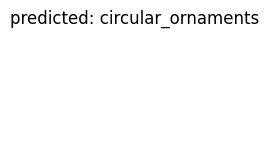

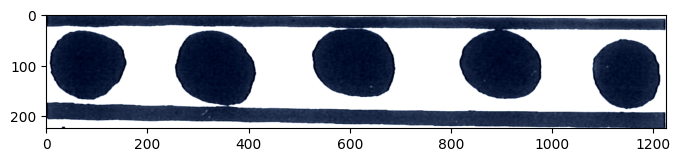

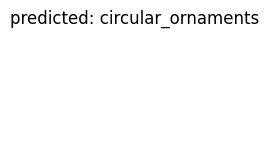

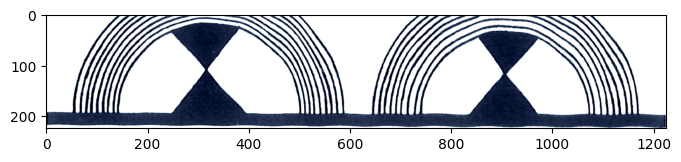

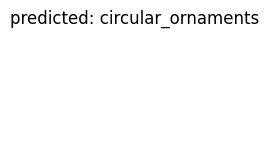

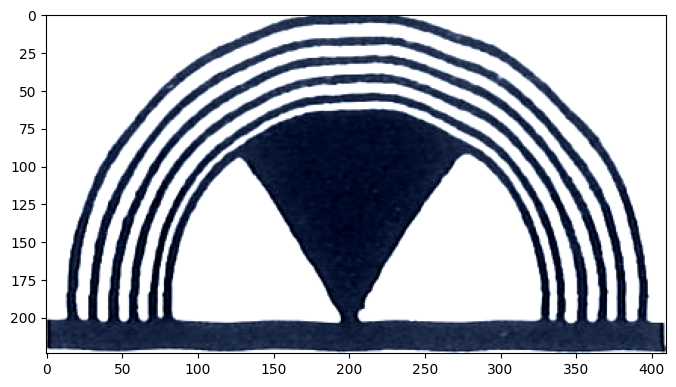

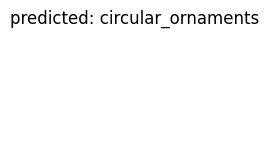

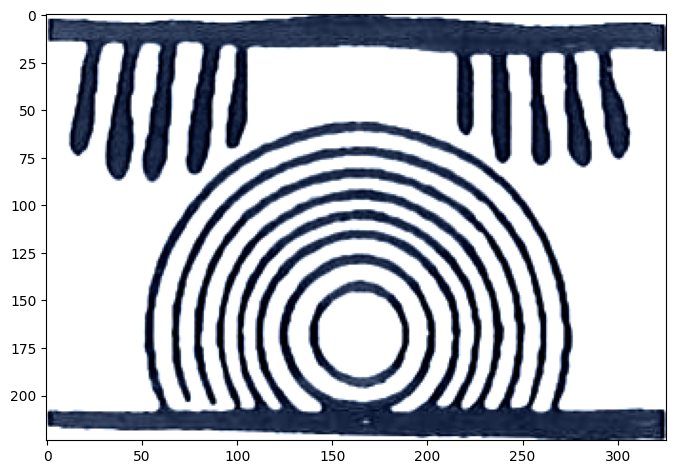

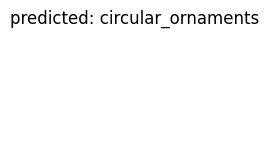

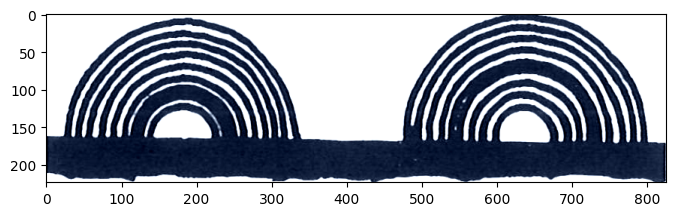

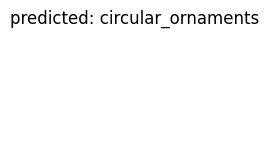

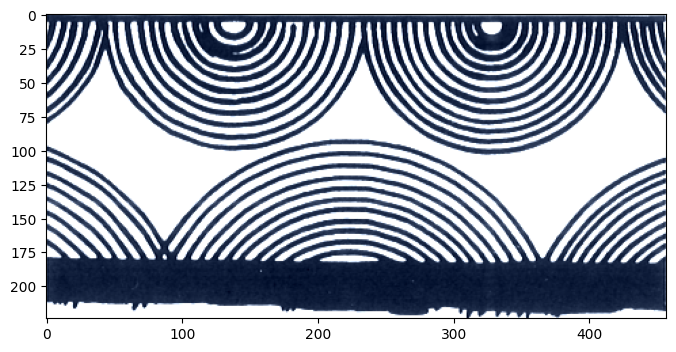

Accuracy en el conjunto de test: 0.8243


In [17]:
# Cargamos el modelo
model_ft = torch.load('/content/efficientnetb1_Adam_0.001_acc_0.8243243243243243.pt')

#########################################################################################

# Visualización de predicciones del modelo
visualize_model(model_ft)

# Accuracy de test
test_accuracy = calculate_accuracy(model_ft, test_loader)
print(f'Accuracy en el conjunto de test: {test_accuracy:.4f}')

In [ ]:
torch.save(model_ft, f'efficientnetb1_Adam_{learning_rate}_acc:{test_accuracy}.pt')

Para realizar fine-tuning se probaron gran parte de los modelos pre-entrenados por Pytorch a excepción de los modelos transformers y otros. Las pruebas se realizaron variando distintos parámetros e hiperparámetros del entrenamiento, en particular se probó con dos optimizadores, el Stochastic Gradient Descendent(SGD) y el Adaptive Moment Estimation (Adam), a los cuales se les fué modificando los hieperparámetros de learning rate, momentum y weight decay, lo último para aplicar el método L2 Regularization, por último, dependiendo del modelo, también se probó modificando la probabilidad de la capa de Dropout en el classifier del modelo.


El enfoque fue probar con las estructuras no tan complejas, es decir que no fueran demasiada profundas ni que tuviera una gran cantidad de parámetros debido a la poca cantidad de data que se tenía disponible. En un inicio se probó con la configuración default que proporciona Pytorch para realizar fine-tuning, el cual corresponde a utilizar el optimizador SGD con un learning rate de 0.001 y un momentum de 0.9, sin embargo en la mayoría de los modelos se fue observando que a medida que avanzaban las épocas existía un gran overfitting(diferencia mayor a 5% entre el accuracy de train y validation) a pesar de que la función de entrenamiento se diseñó tal que entregara el modelo con el mayor accuracy de validación entre todas las épocas y que cumpliera con el criterio de no overfitting, pero aún así los resultados no eran suficientes, ya que al menos se esperaba tener sobre un 60% de accuracy de test, sin embargo se seguían obteniendo resultados inferiores.

Posteriormente, se intentó aplicar L2 Regularization mediante la variación del parámetro "weight_decay" para poder controlar el overfitting del modelos, además de variar los hiperparámetros de learning rate y momentum en los optimizadores para encontrar la mejor configuración que me entregara un accuracy de test igual o mayor al esperado. De esta forma se pudo obtener un grupo de modelo con los cuales se logró lo cometido, estos fueron: VGG16, VGG19, ResNet101 y EfficientNetB1. En los primeros dos modelos se utilizaron sus configuraciones con batch normalization, por la parte de sus estructuras, VGG16_bn tiene tres bloques de convolución, mientras que VGG19_bn tiene cuatro. Ambos modelos utilizan la función de activación ReLU y pueden incluir capas de Dropout para regularización. La adición de batch normalization en estas redes ayuda a mejorar la convergencia y el rendimiento.

Por otra parte, el modelo de ResNet101 es un modelo de red neuronal profunda que consta de 101 capas y forma parte de la familia de redes residuales (ResNet), la cual se caracteriza por su profundidad y la inclusión de conexiones residuales que sirven para lidiar con el problema de la desaparición del gradiente y facilitan el entrenamiento de redes más profundas. Por último, el modelo EfficientNetB1 es un modelo que pertenece a la familia de modelo EfficientNet la cual está diseñada para lograr un equilibrio entre el rendimiento y la eficiencia computacional al optimizar el tamaño y la arquitectura de la red. El modelo B1 utiliza una combinación de bloques de atención y convoluciones profundas para capturar características complejas en imágenes. Su estructura escalable permite equilibrar el rendimiento y la eficiencia, lo que lo hace adecuado para aplicaciones que requieren un buen compromiso entre la precisión y los recursos computacionales.

Finalmente, el modelo con el que se obtuvo el mayor accuracy de test sin overfitting fue con el modelo EfficientNetB1, utilizando el optimizador Adam y un learning rate de 0.001, este modelo obtuvo un valor de accuracy de test de 82% aproximadamente. Si bien es un gran valor de accuracy, hay que entender que no siempre es necesario obtener el mayor accuracy cercano a 99%, ya que depende mucho del problema y de la disposición de datos, sus distribuciones, etc. Para este problema se disponía de una pequeña cantidad de datos, los cuales se distribuyeron en data de train, validation y test, y que a pesar de que se transformaron para una distribución acorde a los modelos, en muchos casos se obtuvo un accuracy de validación alto, pero un accuracy de test más bajo, lo cual se puede deber a una falta en la generalización del modelo o un problema en la distribución de los datos de test. Por lo mismo, se dispuso de un accuracy de test válido en 60%, ya que a criterio personal es una métrica suficiente para tener un modelo decente capaz de generalizar la poca data disponible.

**Nota: el modelo entrenado viene adjunto a este notebook, se recomienda solamente cargarlos al directorio y correr el bloque de código de la parte superior si es necesario.**

# Solución 2: Freezing

Utiliza freezing para el problema anterior y reporta el accuracy de test. Intenta obtener el accuracy de test más alto posible, sin que el modelo haga overfitting. Considera overfitting
ting cuando la diferencia entre accuracy de train y accuracy de validación tengan una diferencia de más de 5%.

In [23]:
# Freeze

# Carga del modelo pre-entrenado
model_conv = models.efficientnet_b1(pretrained=True)

# Fijamos los pesos de las capas convolucionales
for param in model_conv.parameters():
  param.requires_grad = False

num_classes = len(class_names) # Clases de dataset de entrada
model_conv.classifier[0] = nn.Dropout(p=0.8, inplace=True) # Modificación de la capa dropout
model_conv.classifier[1] = nn.Linear(model_conv.classifier[1].in_features, num_classes) # Modificación de la última capa FC
model_conv = model_conv.to(device)

# Parámetros para entrenamiento
criterion = nn.CrossEntropyLoss()
learning_rate=0.01
momentum=0.98
weight_decay=0.1

optimizer_conv = torch.optim.SGD(model_conv.classifier.parameters(), lr = learning_rate, momentum=momentum, weight_decay=weight_decay )
# optimizer_conv = torch.optim.Adam(model_conv.classifier.parameters(), lr=learning_rate,)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma = 0.1)

# Entrenamiento del modelo pre-entrenado
model_conv = train_model(model_conv, criterion, optimizer_conv, scheduler=exp_lr_scheduler, num_epochs=10)


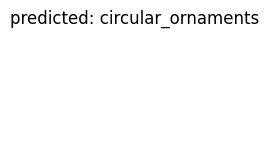

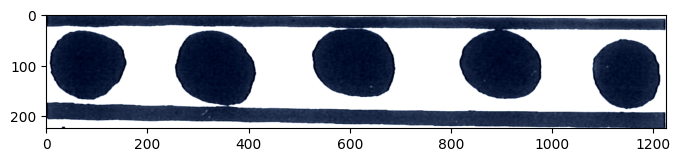

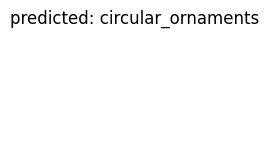

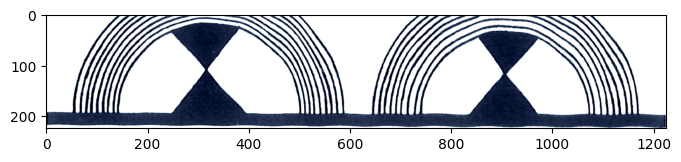

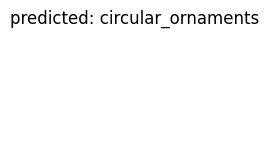

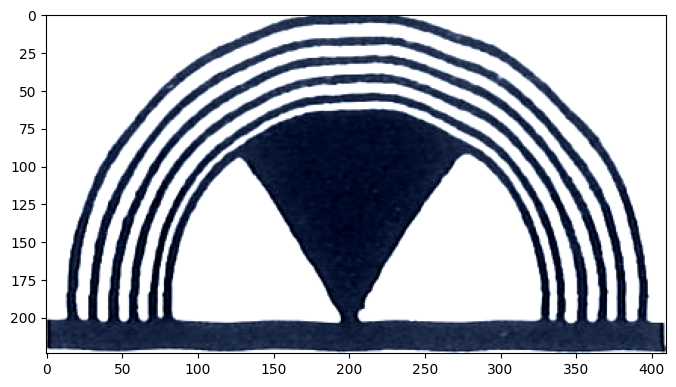

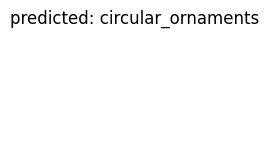

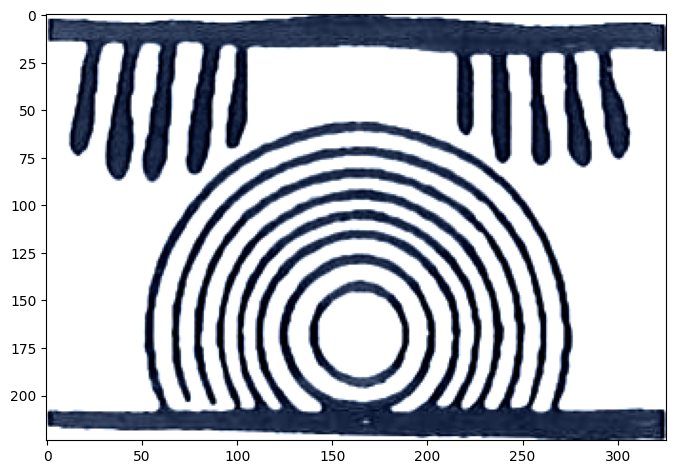

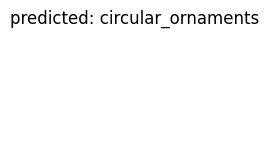

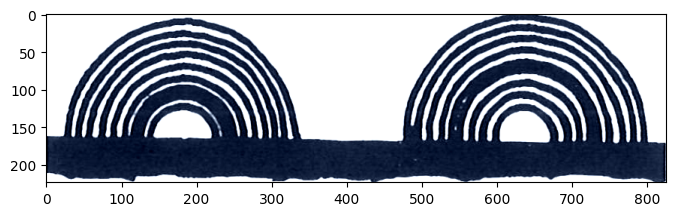

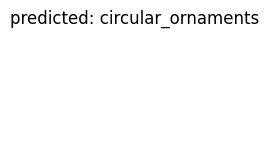

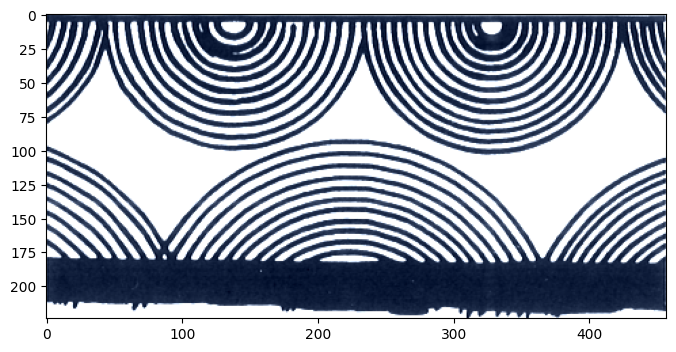

Accuracy en el conjunto de test: 0.7297


In [24]:
# Cargamos el modelo
model_conv = torch.load('/content/efficientnetb1_drop_0.8_SGD_lr_0.01_m_0.98_wd_0.1_acc_0.7297297297297298.pt')

# Visualización de predicciones del modelo
visualize_model(model_conv)

# Accuracy de test
test_accuracy = calculate_accuracy(model_conv, test_loader)
print(f'Accuracy en el conjunto de test: {test_accuracy:.4f}')

In [ ]:
torch.save(model_ft, f'efficientnetb1_drop_0.8_SGD_lr:{learning_rate}_m:{momentum}_wd:{weight_decay}_acc:{test_accuracy}.pt')

Para realizar el proceso de Freeze se siguió prácticamente el mismo procedimiento que con Fine-tuning, las principales diferencias radican en la forma de entrenar el modelo y los resultados obtenidos. El método de Freeze se enfoca en entrenar la parte final del modelo convolucional, es decir donde se encuantras las capas fully-connected, a diferencia del método de Fine-tuning, el cual re-entrena el modelo completo, incluyendo las capas convolucionales.

De la misma forma que el método anterior, se dejó un accuracy de test válido en 60%, ya que se espera que a partir de este valor de la métrica el modelo sea lo suficientemente capaz de generalizar lo mejor posible la data de entrenamiento. Para el entrenamiento se tuvieron que congelar los pesos de las capas convolucionales debido al objetivo del método de Freeze, y se probaron distintos modelos variando los parámetros e hiperparámetros de estos, al igual que en el caso de Fine-tuning.

Finalmente, el modelo con el cual se obtuvo el mayor accuracy de test sin overfitting fue el mismo que en Fine-tunning, el modelo EfficientNetB1, pero ahora utilizando el optimizador SGD, con un learnign rate de 0.01, un momentum de 0.98 y un weight decay de 0.1, además de una modificación en la probabilidad de la capa Dropout pasandola de 0.2 a 0.8. De esta forma se obtuvo un accuracy de test de 72% aproximadamente, lo cual es un resultado inferior al obtenido con Fine-tuning y algo no esperado, ya que por como está diseñado el modelo de Freeze se esperaba que se obtuviera un resultado mejor que en Fine-tuning al solamente enfocar su entrenamiento en las capas fully-connected y no en las capas convolucionales. Esto pudo haber sucedido debido a que el resultado obtenido con Fine-tuning fue un resultado aleatorio que se obtuvo de forma única y particular, ya que el realizar las pruebas en Fine-tuning los entrenamientos simpre fueron más o menos inestables, es decir que en la mayoría de las épocas había overfitting y en épocas particulares el accuracy de validacion y entrenamiento aumentaban y se asemejaban, sin embargo no era un resultado que se mantuviera a lo largo del entrenamiento, de hecho después el accuracy de validación disminuia aún más. Sin embargo, en los entrenamientos de Freeze se pudo observar un cierto grado de estabilidad en los entrenamientos, de hecho en muchos de ellos se obtuvieron casi todas las épocas sin overfitting, pero con un resultado en test inferior a 60%, lo cual da cuenta de que este método tiene ciertas ventajas por sobre el Fine-tuning.

**Nota: el modelo entrenado viene adjunto a este notebook, se recomienda solamente cargarlos al directorio y correr el bloque de código de la parte superior si es necesario.**